In [1]:
pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 12.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.datasets import make_classification
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

import seaborn as sns
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow_text as text #intall using 'pip install tensorflow-text'

In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/converted - Copy.csv')
data.head()

,text,label
0,these tiktoks radiate gay chaotic energy and i...,1
1,@Champions Again He got killed for using false...,1
2,It's not that all lives don't matter,1
3,Is it really that difficult to understand? Bla...,1
4,Whenever we say black isn't that racists? Why...,1


In [6]:
data.shape

(22743, 2)

In [7]:
data.label.value_counts()

1    20781
0     1962
Name: label, dtype: int64

In [8]:
X = data.iloc[:,:-1]
y = data.label
X.head()

,text
0,these tiktoks radiate gay chaotic energy and i...
1,@Champions Again He got killed for using false...
2,It's not that all lives don't matter
3,Is it really that difficult to understand? Bla...
4,Whenever we say black isn't that racists? Why...


In [9]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
X.loc[:,['text']] = \
X.loc[:,['text']].apply(enc.fit_transform)
X.head()

<ipython-input-9-7e2fafe9e82b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,['text']] = \


,text
0,21011
1,897
2,11073
3,10712
4,18228


# Under Sampling

In [12]:
df_hope = data[data['label']==0]
df_hope.shape

(1962, 2)

In [14]:
df_nhope = data[data['label']==1]
df_nhope.shape

(20781, 2)

In [15]:
df_nhope_downsampled = df_nhope.sample(df_hope.shape[0])
df_nhope_downsampled.shape

(1962, 2)

In [16]:
df_balanced = pd.concat([df_hope, df_nhope_downsampled])
df_balanced.shape

(3924, 2)

In [17]:
df_balanced['label'].value_counts()

0    1962
1    1962
Name: label, dtype: int64

In [18]:
df_balanced.sample(5)

,text,label
1196,@DANIEL LEEPER nothing was sexual in the discu...,0
2564,This US election seems like a half-baked SNL s...,1
14921,I was the girl who played with my brother's le...,0
17566,Growing up never think of gays lesbians . toda...,1
15413,wow its so amazing to knw about u... amazing i...,0


In [19]:
df_balanced['Category'] = df_balanced['label'].apply(lambda x: 'Hope' if x==0 else 'Non-hope')
df_balanced.sample(10)

,text,label,Category
8383,What are you talking about?,1,Non-hope
18285,All lives do matter! To say otherwise creates ...,0,Hope
7140,I'm lesbian and one thing that bothers me is w...,0,Hope
21040,I got a degree in chemical engineering because...,0,Hope
22234,I guess this is a better start to getting us b...,0,Hope
12497,They want black voters!,1,Non-hope
17046,They say that politics is the second oldest pr...,1,Non-hope
8460,ALL LIVES MATTER WE ARE ALL GODS CHILDREN ANYO...,0,Hope
21721,I agree with every word you said I couldn't of...,1,Non-hope
8226,Thank you so much for this! I'm a high school ...,0,Hope


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['text'],df_balanced['label'], stratify=df_balanced['label'])

In [27]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [28]:
#Bert Layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#NN layers
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer_4 (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                            

In [30]:
METRICS  = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics=METRICS)

In [31]:
model.fit(X_train,y_train)
y_predict = model.predict(X_test)

31/31 [==============================] - 504s 16s/step


In [35]:
model.evaluate(X_test, y_test)

31/31 [==============================] - 518s 17s/step - loss: 0.6382 - accuracy: 0.6422 - precision: 0.6708 - recall: 0.5571


[0.6381840705871582, 0.642201840877533, 0.6707616448402405, 0.5571428537368774]

In [36]:
y_predict = y_predict.flatten()

In [39]:
import numpy as np

y_predict = np.where(y_predict > 0.5, 1, 0)
y_predict

array([1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,

In [40]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predict)
cm

array([[357, 134],
       [217, 273]])

Text(50.722222222222214, 0.5, 'Truth')

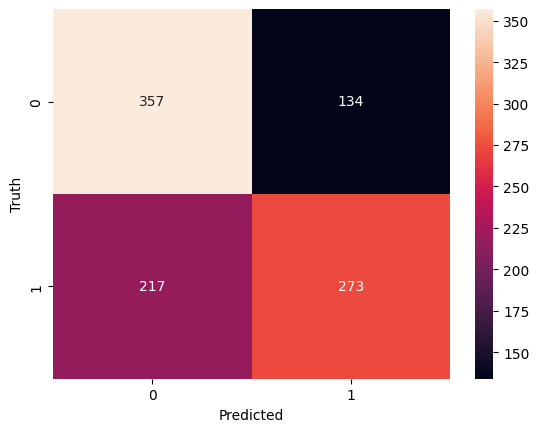

In [41]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [42]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.62      0.73      0.67       491
           1       0.67      0.56      0.61       490

    accuracy                           0.64       981
   macro avg       0.65      0.64      0.64       981
weighted avg       0.65      0.64      0.64       981



In [43]:
reviews = [
    'The World is a better place',
    'i should die'
]
model.predict(reviews)

1/1 [==============================] - 3s 3s/step


array([[0.7038489 ],
       [0.79488415]], dtype=float32)